### Load the data

In [14]:
# Import necessary libraries
import pandas as pd

df = pd.read_csv("data/us-insurance-data.csv", sep=",")

### Convert 'charges' into a categorical target variable


In [15]:
median_charges = df['charges'].median()
df['charges_cat'] = df['charges'].apply(lambda x: 1 if x > median_charges else 0)
df = df.drop('charges', axis=1)

### Encode categorical variables into numerical variables


In [16]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical columns
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])


### Process and replace columns in the DataFrame

In [17]:
import numpy as np

# Features and target variable
x = df.drop('charges_cat', axis=1)
y = df['charges_cat']

# Fit and transform the features
x_preprocessed = preprocessor.fit_transform(x)

# Get feature names
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([num_features, cat_features])

# Create a DataFrame with preprocessed features
X_preprocessed_df = pd.DataFrame(x_preprocessed, columns=feature_names)
X_preprocessed_df.reset_index(drop=True, inplace=True)
y = y.reset_index(drop=True)


### Split the data into training and testing sets

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed_df, y, test_size=0.30, random_state=42, stratify=y
)

### Train the Decision Tree Classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth = 5) # Checked with Gini and greater max_depth but the actual seem to work bring best results
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

### Evaluate the model

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score

y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('\nR2 Score:', r_squared)
print('\nConfusion Matrix:\n', conf_matrix)


Accuracy: 0.9353233830845771

R2 Score: 0.7412935323383085

Confusion Matrix:
 [[193   8]
 [ 18 183]]


### Plot the decision tree

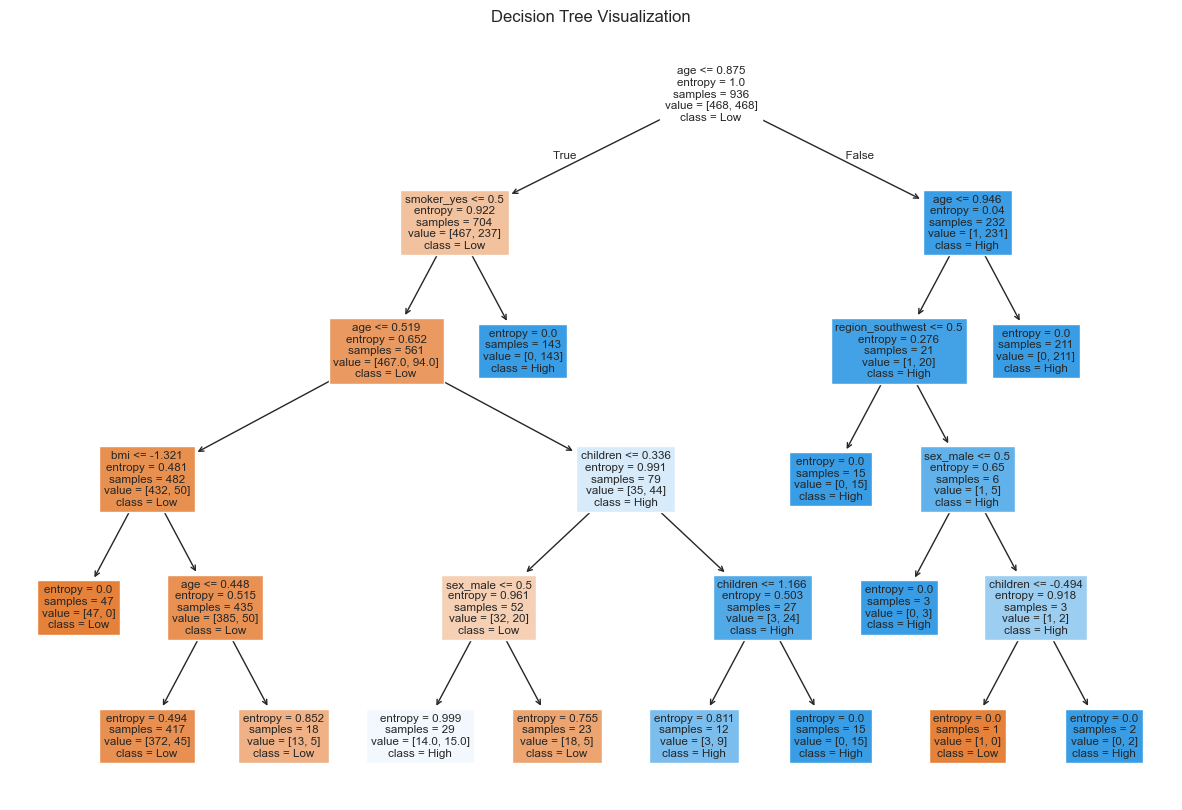

In [21]:
import matplotlib.pyplot as plt
from sklearn import tree

# Optional: Visualize the decision tree
plt.figure(figsize=(15, 10))
tree.plot_tree(
    dt_classifier,
    feature_names=feature_names,
    class_names=['Low', 'High'],
    filled=True
)
plt.title('Decision Tree Visualization')
plt.show()


## Random Forest

In [22]:
### Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5, max_depth=2, random_state=7)

### train the model

In [23]:
rf.fit(X_train, y_train) 
estimator = rf.estimators_
y_predito_random_forest = rf.predict(X_test) 

### Plot the decision tree

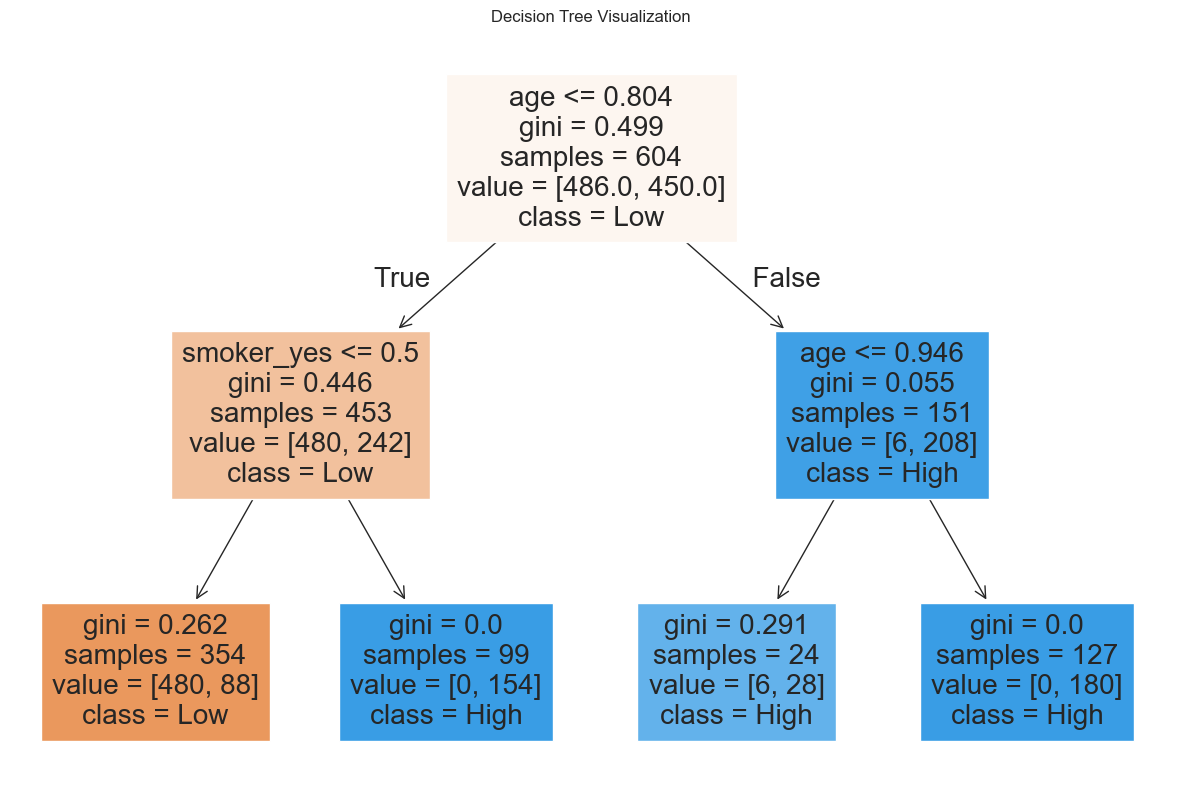

In [24]:
plt.figure(figsize=(15, 10))
tree.plot_tree(
    rf.estimators_[0],
    feature_names=feature_names,
    class_names=['Low', 'High'],
    filled=True
)
plt.title('Decision Tree Visualization')
plt.show()

### Evaluate the model

In [25]:
from sklearn.metrics import roc_curve, auc

print(accuracy_score(y_test, y_predito_random_forest))
print (rf.score(X_train, y_train))
print(rf.score(X_test, y_test))


0.917910447761194
0.9006410256410257
0.917910447761194


In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score

y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_predito_random_forest)
conf_matrix = confusion_matrix(y_test, y_predito_random_forest)
class_report = classification_report(y_test, y_predito_random_forest)
r_squared = r2_score(y_test, y_predito_random_forest)

print('Accuracy:', accuracy)
print('\nR2 Score:', r_squared)
print('\nConfusion Matrix:\n', conf_matrix)

Accuracy: 0.917910447761194

R2 Score: 0.6716417910447761

Confusion Matrix:
 [[200   1]
 [ 32 169]]


### ROC and AUC Curve

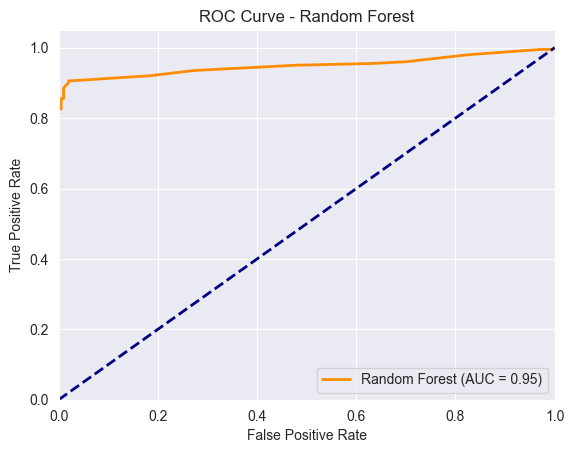

In [26]:
# Predict probabilities
y_pred_prob_rf = rf.predict_proba(X_test)[:,1]

# Compute ROC curve and ROC area
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()